In [1]:
#导入必要的库
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.layers import *
from keras.models import *
from keras.optimizers import Adam
from keras.optimizers import Nadam

# 使用sklearn调用衡量模型的MSE 、 RMSE、 MAE、r2
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, mean_absolute_percentage_error

In [2]:
# 设置随机种子
np.random.seed(1234)

# tensorflow V2.x
# For Tensorflow 2.0 tf.random.set_random_seed(seed) changed to tf.random.set_seed(seed).
tf.random.set_seed(1234)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import csv
import os
directory='/content/drive/My Drive/taidi/'
filename='day_sum.csv'
filepath=os.path.join(directory,filename)

In [5]:
# 读取数据
# df = pd.read_csv('./全部数据/order_train1.csv',parse_dates=["order_date"],index_col=[0])   # 把日期变为索引
# df = pd.read_csv('./全部数据/order_train1.csv')   
df = pd.read_csv(filepath)  

first_col = df.pop('ord_qty')
df.insert(1, 'ord_qty', first_col)  #把订单量变为第一列

display(df)  
df.info()

,order_date,ord_qty,item_code,sales_region_code,first_cate_code,second_cate_code,year,month,day,item_price,brand_qty_median,lag_30,rmean_30_30
0,2015/9/1,12,20028,104,301,405,2015,9,1,1012.000000,28,0,0.000000
1,2015/9/1,19,22069,104,307,403,2015,9,1,1114.000000,41,0,0.000000
2,2015/9/2,18,20657,101,303,410,2015,9,2,2996.000000,22,0,0.000000
3,2015/9/2,502,20323,102,305,412,2015,9,2,99.000000,28,4,246.433333
4,2015/9/2,308,20457,102,305,412,2015,9,2,164.000000,28,155,230.533333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
376471,2018/12/20,10,22006,105,302,408,2018,12,20,755.500000,24,0,0.000000
376472,2018/12/20,7,22028,105,305,412,2018,12,20,246.000000,28,4,18.233333
376473,2018/12/20,56,22058,105,302,408,2018,12,20,1354.666667,24,5,76.100000
376474,2018/12/20,248,22072,105,305,412,2018,12,20,427.000000,28,35,0.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376476 entries, 0 to 376475
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   order_date         376476 non-null  object 
 1   ord_qty            376476 non-null  int64  
 2   item_code          376476 non-null  int64  
 3   sales_region_code  376476 non-null  int64  
 4   first_cate_code    376476 non-null  int64  
 5   second_cate_code   376476 non-null  int64  
 6   year               376476 non-null  int64  
 7   month              376476 non-null  int64  
 8   day                376476 non-null  int64  
 9   item_price         376476 non-null  float64
 10  brand_qty_median   376476 non-null  int64  
 11  lag_30             376476 non-null  int64  
 12  rmean_30_30        376476 non-null  float64
dtypes: float64(2), int64(10), object(1)
memory usage: 37.3+ MB


In [6]:
testset_start = df[(df.year==2018)&(df.month==9)].index.tolist()[0]
testset_end = df[(df.year==2018)&(df.month==11)].index.tolist()[-1]
print(testset_start, testset_end)

323196 367263


In [7]:
#设置LSTM的时间窗等参数
window = 60  # 60 3 30 300
lstm_units = 200  # 100 200
dropout = 0.01  
epoch=100  # 最大epoch, 会早停
batch_size = 280  # 128 280 480
activation='tanh'

In [8]:
y = df['ord_qty']

# 数据标准化，选用min-max方法，以提高神经网络性能
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))  # scale of the output and input in the range 0–1 to match the scale of the layer of LSTM
y=scaler.fit_transform(np.array(y).reshape(-1,1)) # reshape:convert the univariate 1D array into 2D  # n行1列
print(y.shape)


(376476, 1)


In [9]:
# 拆分训练/验证集
# train_size = int(len(y) * 0.9)
# # test_size = len(df) - train_size
# df_for_training=y[0:train_size,:]
# df_for_testing=y[train_size:len(y),:1]

df_for_training=y[0:testset_start-1,:]
df_for_testing=y[testset_start:testset_end,:1]

# input_size=len(df.iloc[1,:])  # 特征数量
input_size = 1

print(df_for_training.shape)
print(df_for_testing.shape)

(323195, 1)
(44067, 1)


In [10]:
# import numpy as np
# import pandas as pd
# from sklearn import preprocessing
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import MinMaxScaler

# # 数据标准化
# scaler = MinMaxScaler(feature_range=(0,1))
# df_for_training_scaled = scaler.fit_transform(df_for_training)
# df_for_testing_scaled=scaler.transform(df_for_testing)

In [11]:
# 分X,Y
def createXY(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-window-1):  # Time Series setps (0-99,100-200,,,,) any steps
		a = dataset[i:(i+window), 0]   
		dataX.append(a)
		dataY.append(dataset[i + window, 0]) #第一列为订单量
	return np.array(dataX), np.array(dataY)

time_step = window
trainX,trainY=createXY(df_for_training,window)
testX,testY=createXY(df_for_testing,window)

# reshape X
trainX = trainX.reshape(trainX.shape[0],trainX.shape[1],1)
testX = testX.reshape(testX.shape[0],testX.shape[1],1)

In [12]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)
# print(trainX.shape[2])

(323134, 60, 1)
(323134,)
(44006, 60, 1)
(44006,)


In [13]:
#建立LSTM模型 训练

# 优化器
my_adam = Adam(learning_rate=0.001)
my_nadam = Nadam(learning_rate = 0.001)

inputs=Input(shape=(window, input_size))
# model=Conv1D(filters = lstm_units, kernel_size = 1, activation = 'sigmoid')(inputs)#卷积层
# model=MaxPooling1D(pool_size = window)(model)#池化层
# model=Dropout(dropout)(model)#droupout层
# 第一层LSTM，12是单元个数超参数，多层LSTM前面几层必须return_sequences=True，输入window个时间步，input_size个特征
model=Bidirectional(LSTM(lstm_units, activation=activation,return_sequences=True), name='bilstm')(inputs)#双向LSTM层
model=Dropout(dropout)(model)#droupout层
# 最后一层LSTM,return_sequences=False
model=Bidirectional(LSTM(lstm_units, activation=activation, return_sequences=False),name='bilstm2')(model)
model=Dropout(dropout)(model)#droupout层
# attention=Dense(lstm_units, activation='sigmoid', name='attention_vec')(model)#求解Attention权重
# model=Multiply()([model, attention])#attention与LSTM对应数值相乘
outputs = Dense(1, activation='tanh')(model)
model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='mse',optimizer=my_nadam)


# model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
# model.compile(loss='mse',optimizer=my_nadam)
model.summary()#展示模型结构

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60, 1)]           0         
                                                                 
 bilstm (Bidirectional)      (None, 60, 400)           323200    
                                                                 
 dropout (Dropout)           (None, 60, 400)           0         
                                                                 
 bilstm2 (Bidirectional)     (None, 400)               961600    
                                                                 
 dropout_1 (Dropout)         (None, 400)               0         
                                                                 
 dense (Dense)               (None, 1)                 401       
                                                                 
Total params: 1,285,201
Trainable params: 1,285,201
Non-train

In [14]:
# use early stop to avoid over-fiting  早停法防止过拟合,若loss不减小，训练停止
from tensorflow.keras.callbacks import EarlyStopping
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=20, 
        verbose=1, mode='auto', restore_best_weights=True)

# 模型训练
history=model.fit(trainX, trainY, epochs = epoch, batch_size = batch_size, shuffle=False,callbacks=[monitor], validation_data=(testX, testY)) #训练模型epoch次

Epoch 1/100
1155/1155 [==============================] - 86s 64ms/step - loss: 3.9184e-04 - val_loss: 1.9275e-04
Epoch 2/100
1155/1155 [==============================] - 74s 64ms/step - loss: 2.1452e-04 - val_loss: 1.9041e-04
Epoch 3/100
1155/1155 [==============================] - 76s 65ms/step - loss: 2.1385e-04 - val_loss: 1.9126e-04
Epoch 4/100
1155/1155 [==============================] - 77s 67ms/step - loss: 2.1364e-04 - val_loss: 1.9144e-04
Epoch 5/100
1155/1155 [==============================] - 78s 67ms/step - loss: 2.1343e-04 - val_loss: 1.9059e-04
Epoch 6/100
1155/1155 [==============================] - 78s 67ms/step - loss: 2.1324e-04 - val_loss: 1.9048e-04
Epoch 7/100
1155/1155 [==============================] - 78s 67ms/step - loss: 2.1325e-04 - val_loss: 1.9024e-04
Epoch 8/100
1155/1155 [==============================] - 78s 67ms/step - loss: 2.1301e-04 - val_loss: 1.9091e-04
Epoch 9/100
1155/1155 [==============================] - 78s 67ms/step - loss: 2.1323e-04 - val_

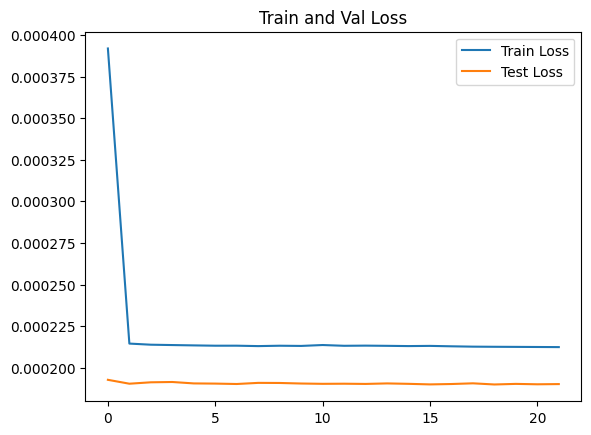

In [15]:
#迭代图像
loss = history.history['loss']
val_loss = history.history['val_loss']
# epochs_range = range(epoch)
epochs_range = range(len(loss))
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Test Loss')
plt.legend(loc='upper right')
plt.title('Train and Val Loss')
plt.show()

In [16]:
# # create the list of difference between prediction and test data
# predictions = model.predict(testX)
# len(predictions)

# # Showing the predicted vs. actual values
# fig, axs = plt.subplots()
# fig.set_figheight(8)
# fig.set_figwidth(15)

# axs.plot(testY,color='blue', label='Actual',linestyle='--',linewidth=1)
# axs.plot(predictions,color='red', label='Predicted',linewidth=1)
# # axs.scatter(outliers.index,outliers, color='green', linewidth=5.0, label='Anomalies')
# plt.title('Prediction  with standardize data')
# plt.xlabel('Time Steps')
# plt.ylabel('Order quantity (Standardized Data)')
# plt.legend(loc='upper left')
# plt.show()

# # plot_1(history1, 'Training / Validation Losses from History')

In [17]:
# # score=model.evaluate(testX,testY,verbose=0)
# # print('Test mse with Standardized Data:')
# # print(score)
# # # print('Test Loss:',score[0])
# # # print('Test mae:',score[1])

# # 使用sklearn调用衡量模型的MSE 、 RMSE、 MAE、r2
# print('----------with standarded data----------')
# print("mean_absolute_error:", mean_absolute_error(testY, predictions))
# print("mean_squared_error:", mean_squared_error(testY, predictions))
# print("rmse:", sqrt(mean_squared_error(testY, predictions)))
# print("r2 score:", r2_score(testY, predictions))


1376/1376 [==============================] - 10s 6ms/step
(44006, 1)


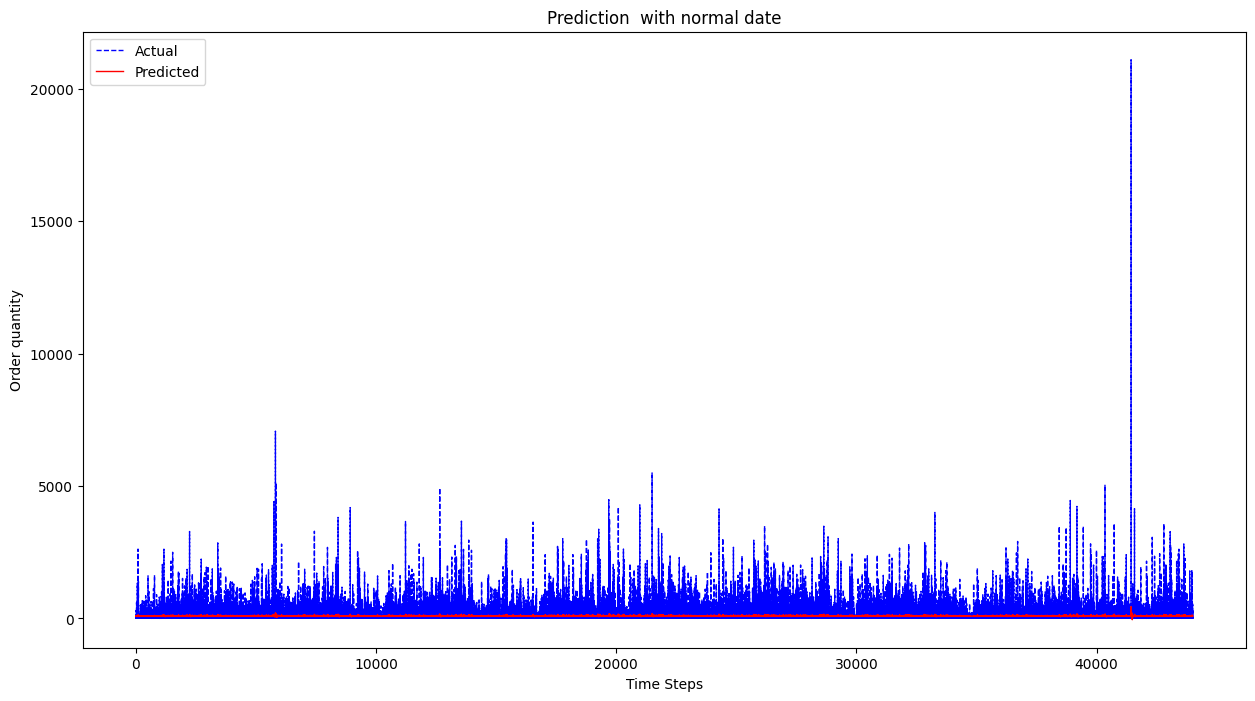

In [18]:
# 还原模型预测

# create the list of difference between prediction and test data
predictions = model.predict(testX)
print(predictions.shape)

# 反归一化
prediction_copies_array = np.repeat(predictions,testX.shape[2], axis=-1)
predictions_inv=scaler.inverse_transform(np.reshape(prediction_copies_array,(len(predictions),testX.shape[2])))[:,0]

testY_copies_array = np.repeat(testY,testX.shape[2], axis=-1)
testY_inv=scaler.inverse_transform(np.reshape(testY_copies_array,(len(testY),testX.shape[2])))[:,0]


# Showing the predicted vs. actual values
fig, axs = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(15)

axs.plot(testY_inv,color='blue', label='Actual',linestyle='--',linewidth=1)
axs.plot(predictions_inv,color='red', label='Predicted',linewidth=1)
# axs.scatter(outliers.index,outliers, color='green', linewidth=5.0, label='Anomalies')
plt.title('Prediction  with normal date')
plt.xlabel('Time Steps')
plt.ylabel('Order quantity')
plt.legend(loc='upper left')
plt.show()


In [19]:

# df_test_copy = df_for_testing[0:-window-1,:]
df_test_copy = df.iloc[testset_start:testset_end-window-1,1:]
df_test_copy.insert(loc=0, column='ord_qty_pre', value = predictions_inv)
df_test_copy = df_test_copy.groupby(['year','month','sales_region_code', 'item_code', 'first_cate_code','second_cate_code'],as_index=False).agg({'ord_qty': 'sum', 'ord_qty_pre':'sum'})
display(df_test_copy)


,year,month,sales_region_code,item_code,first_cate_code,second_cate_code,ord_qty,ord_qty_pre
0,2018,9,101,20002,303,406,45,283.475281
1,2018,9,101,20003,301,405,93,278.314911
2,2018,9,101,20006,307,403,109,372.255096
3,2018,9,101,20014,307,403,16,189.747070
4,2018,9,101,20016,303,401,930,981.180664
...,...,...,...,...,...,...,...,...
5764,2018,11,105,22059,305,412,37,191.058289
5765,2018,11,105,22066,307,403,10008,1295.074463
5766,2018,11,105,22072,305,412,1514,1339.549438
5767,2018,11,105,22081,303,401,15,193.408417


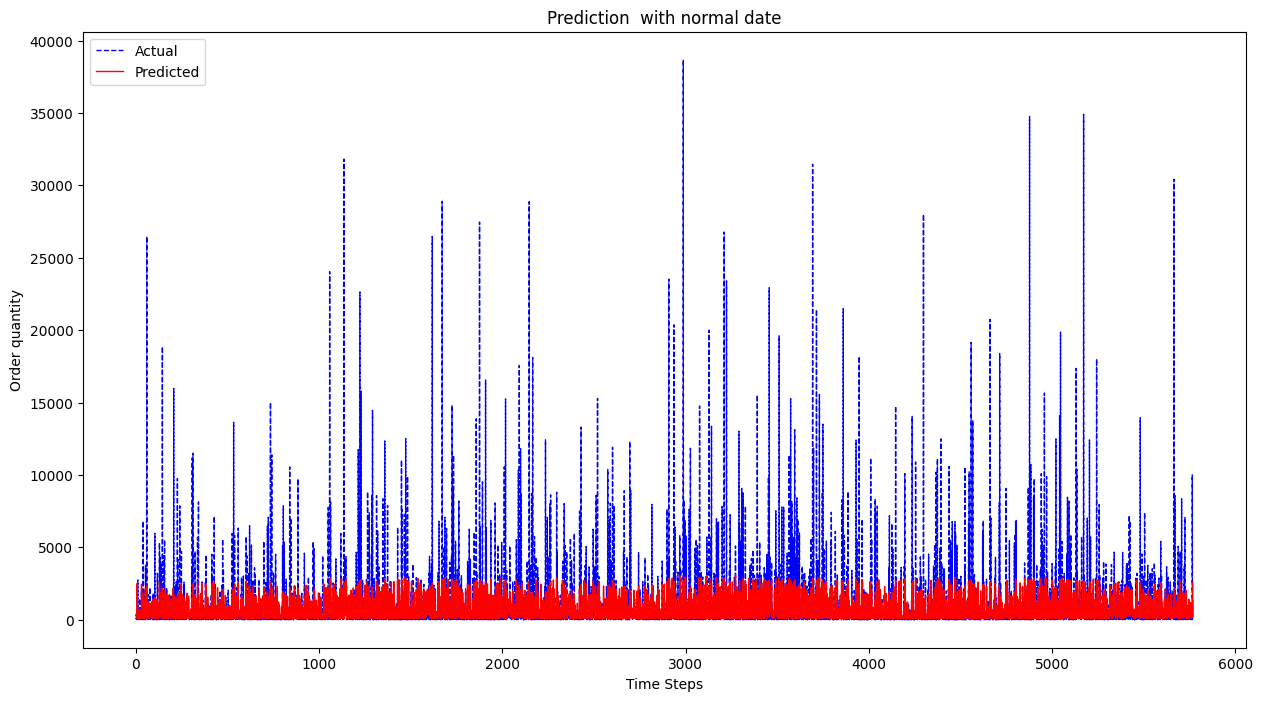

In [20]:
# 还原模型预测

# # create the list of difference between prediction and test data
# predictions = model.predict(testX)
# print(predictions.shape)

# # 反归一化
# prediction_copies_array = np.repeat(predictions,testX.shape[2], axis=-1)
# predictions_inv=scaler.inverse_transform(np.reshape(prediction_copies_array,(len(predictions),testX.shape[2])))[:,0]

# testY_copies_array = np.repeat(testY,testX.shape[2], axis=-1)
# testY_inv=scaler.inverse_transform(np.reshape(testY_copies_array,(len(testY),testX.shape[2])))[:,0]

# Showing the predicted vs. actual values
fig, axs = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(15)

axs.plot(df_test_copy['ord_qty'],color='blue', label='Actual',linestyle='--',linewidth=1)
axs.plot(df_test_copy['ord_qty_pre'],color='red', label='Predicted',linewidth=1)
# axs.scatter(outliers.index,outliers, color='green', linewidth=5.0, label='Anomalies')
plt.title('Prediction  with normal date')
plt.xlabel('Time Steps')
plt.ylabel('Order quantity')
plt.legend(loc='upper left')
plt.show()


In [21]:
# 使用sklearn调用衡量模型的MSE 、 RMSE、 MAE、r2
print('------------验证集-周-------------')
print("mae:", mean_absolute_error(testY_inv, predictions_inv))
print("mape:", mean_absolute_percentage_error(testY_inv, predictions_inv))
print("mse:", mean_squared_error(testY_inv, predictions_inv))
print("rmse:", sqrt(mean_squared_error(testY_inv, predictions_inv)))
print("r2:", r2_score(testY_inv, predictions_inv))

print('------------验证集-月-------------')
print("mae:", mean_absolute_error(df_test_copy['ord_qty'], df_test_copy['ord_qty_pre']))
print("mape:", mean_absolute_percentage_error(df_test_copy['ord_qty'], df_test_copy['ord_qty_pre']))
print("mse:", mean_squared_error(df_test_copy['ord_qty'], df_test_copy['ord_qty_pre']))
print("rmse:", sqrt(mean_squared_error(df_test_copy['ord_qty'], df_test_copy['ord_qty_pre'])))
print("r2:", r2_score(df_test_copy['ord_qty'], df_test_copy['ord_qty_pre']))

------------验证集-周-------------
mae: 128.65203069707607
mape: 5.786616884012777
mse: 84685.48304891991
rmse: 291.00770273125056
r2: -0.011852520963474111
------------验证集-月-------------
mae: 772.6663195536814
mape: 5.714680185034035
mse: 5201241.892146953
rmse: 2280.623136808656
r2: 0.23729571884812262
